In [1]:
using NCDatasets
#import Pkg; Pkg.add("NCDatasets")
using PyCall
pushfirst!(pyimport("sys")."path", "");
pyTables = pyimport("lkTables")
pyTables_=pyTables.scattTables()


<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): dim_0(289), dim_1(8)
    variables(dimensions): float32 kextR(dim_0, dim_1), float32 salbR(dim_0, dim_1), float32 asymR(dim_0, dim_1), float32 kextS(dim_0, dim_1), float32 salbS(dim_0, dim_1), float32 asymS(dim_0, dim_1), float32 kextG(dim_0, dim_1), float32 salbG(dim_0, dim_1), float32 asymG(dim_0, dim_1)
    groups: 


PyObject <lkTables.scattTables object at 0x13feec640>

In [3]:
include("juliaScattTables.jl")
scatt_tables = scattTables(pyTables_);


In [5]:
function hb(zKum, alpha, beta, dr, srt_piaKu)
    q = 0.2 * log(10)
    zeta = q * beta * alpha * 10.0 .^(0.1 * zKum * beta) * dr
    zetamax = 1.0 - 10.0^(-srt_piaKu / 10 * beta)
    
    if sum(zeta) > zetamax
        eps = 0.9999 * zetamax / sum(zeta)
    else
        eps = 1.0
    end
    corrc = eps * cumsum(zeta)
    dpia= -10.0 ./ beta * log10.(1.0 .- corrc)
    zc = zKum .+ dpia
    return zc, eps, -10 / beta * log10(1 - corrc[end])
end

hb (generic function with 1 method)

In [6]:
alpha_nom=10^(-3.199)
beta_nom=0.71
zKum=[35.,34.,32.,33.,31.0]
zKum=42.0:-0.5:25.0
dr=0.125
print(size(zKum))

(35,)

In [7]:

srt_piaKu=30
zKuF,eps,PIA=hb(zKum, alpha_nom, beta_nom, dr, srt_piaKu)
NwCoeff = [-7.07747934, 4.63232708]
print(PIA)
function invNw(Dm)
    return NwCoeff[2] + NwCoeff[1] * log10(Dm)
end


2.1630473517117546

invNw (generic function with 1 method)

In [8]:
function bisectm(xvec, nv, r)
    n1 = 1
    n2 = nv
    if r < xvec[1]
        return 1
    end
    if r >= xvec[n2]
        return nv
    end
    nmid = div(n1 + n2, 2)
    it = 0
    while !(r >= xvec[nmid] && r < xvec[nmid + 1]) && it < 7
        it += 1
        if r > xvec[nmid]
            n1 = nmid
        else
            n2 = nmid
        end
        nmid = div(n1 + n2, 2)
    end
    return nmid
end

bisectm (generic function with 1 method)

In [68]:

#piaBinL=[]
#@time for i in 1:10000
#    piaBin = 0.0
#    dnp = 0.0
#    alpha_dnw = []
#    dNwBin = []
#    for k in 1:35
#        ibin = bisectm(scatt_tables.zKuR[1:289], 289, zKuF[k])
#        piaBin += scatt_tables.attKuR[ibin] * dr * 2
#        dmBin = scatt_tables.dmr[ibin]
#    end
#    push!(piaBinL,piaBin)
#end
#print(piaBinL[1],' ',piaBinL[end])

function fromhb(zKuF,scatt_tables,dr)
    
    piaBin = 0.0
    dnp = 0.0
    nbins=size(zKuF)[1]
    dmRet=Vector{Float64}(undef,nbins)
    pRateRet=Vector{Float64}(undef,nbins)
    zKaSim=Vector{Float64}(undef,nbins)
    piaKa=0
    for k in 1:nbins
        ibin = bisectm(scatt_tables.zKuR[1:289], 289, zKuF[k])
        piaBin += scatt_tables.attKuR[ibin] * dr * 2
        dmBin = scatt_tables.dmr[ibin]
        pRateRet[k] = scatt_tables.rainRate[ibin]
        dmRet[k] = dmBin
        attKa= scatt_tables.attKaR[ibin]
        piaKa+=attKa*dr
        zKaSim[k] = scatt_tables.zKaR[ibin]-piaKa
        piaKa+=attKa*dr
    end
     
    return piaBin,dmRet,pRateRet,zKaSim
end

fromhb (generic function with 1 method)

In [13]:
readStormData=pyimport("readStormData")
zMeas,bcf,bsfc,bzd,pFlag,reliabF,pType,zFactorF,PIAhybrid,dm,pRate=readStormData.readStormData();

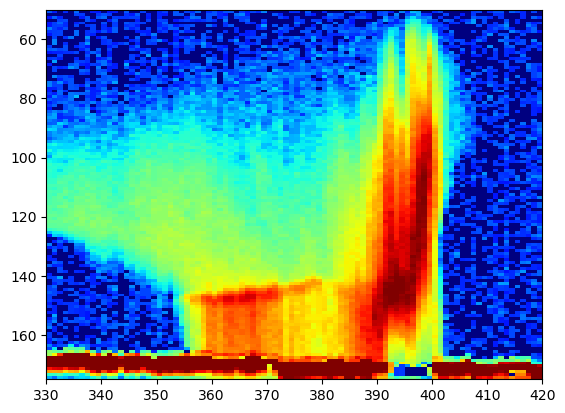

(330.0, 420.0)

In [33]:
# import matplotlib
using PyPlot
#plt=pyimport("matplotlib.pyplot")
pcolormesh(transpose(zMeas[:,25,:,1]),vmin=0,vmax=50,cmap="jet")
ylim(175,50)
xlim(330,420)
#plt.show()

In [76]:
pia1L=[]
pia2L=[]
zKa1L=[]
zKa2L=[]
zKu1L=[]

for i=358:388
        if div(pType[i,25]/1e7,1)==1
            zku1=(zMeas[i,25,bzd[i,25]+6:bcf[i,25],1])
            dn=10.0^((-0.5)*(1-beta_nom))
            zKuF,eps,PIA1=hb(zku1, dn*alpha_nom, beta_nom, dr, srt_piaKu)
            piaBin,dmRet,pRateRet,zKaSim=fromhb(zku1,scatt_tables,dr,dn)
            #println(i,' ',div(pType[i,25]/1e7,1),size(zku1)[1],' ',PIA1)
             
            push!(pia1L,PIA1)
            push!(pia2L,PIAhybrid[i,25,1])
            push!(zKa1L,[zKaSim[1],zKaSim[end]])
            push!(zKa2L,[zMeas[i,25,bzd[i,25]+6],zMeas[i,25,bcf[i,25],2]])
            push!(zKu1L,zku1[end])
            
        end
end

np=pyimport("numpy")
println(np.corrcoef(pia1L,pia2L))
#zKa1L=Float64.(zKa1L)
#zKa2L=Float64.(zKa2L)

[1.0 0.41178108843800565; 0.41178108843800565 1.0]


In [82]:
zKa1L=np.array(zKa1L,dtype=np.float64);
zKa2L=np.array(zKa2L,dtype=np.float64);
print(size(zKa1L))

(26, 2)

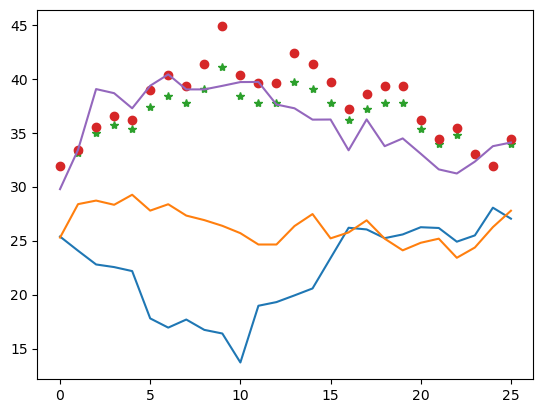

1-element Vector{PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x3035738b0>

In [88]:
plot(zKa1L[:,2])
plot(zKa2L[:,2])
plot(zKa1L[:,1],"*")
plot(zKa2L[:,1],"o")
plot(zKu1L[:])

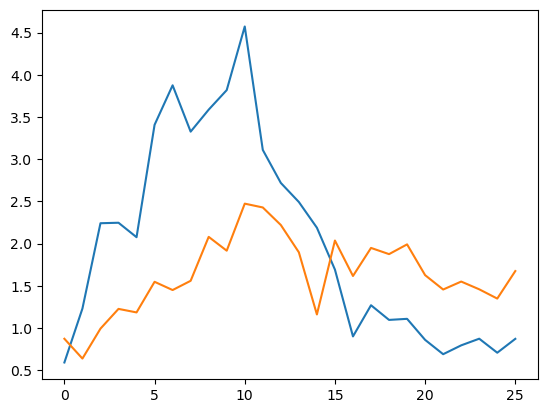

1-element Vector{PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x2fc790f70>

In [71]:
plot(pia1L)
plot(pia2L)